# Getting Started with Python in the Molecular Nanophotonics Group

This Notebook gives an overview on how to handle experimental data in the Moledcular Nanophotoncis Group using Python. It explains how to work with the most commonly used file formats and provides a brief introduction to particle tracking and data analysis. <br>

For a more general introduction to scientific computation using Python see: 'Link zu Franks Vorlesung'

Authors: *Martin Fränzl, Prof. Dr. Frank Cichos*
 

## Default Packages

In [1]:
import numpy as np
pi = np.pi
import matplotlib.pyplot as plt
%matplotlib inline

To get this notebook to work the sample data and the notebook file must be located in the same directory. In general notebook files should be stored along with the experimental data for documentation. The sample data can be found here: 
>`.71/Data/Sample Data`



We recommend to copy large data files to your local drive since down- and upload from the servers can be quite slow. 

## Loading TDMS Files

All experimental data recorded with LabVIEW are stored as TDMS files. To learn more about the TDMS file format see http://www.ni.com/white-paper/3727/en/. <br>
To load TDMS files into Python you need to import the package:

In [2]:
from nptdms import TdmsFile

If you run Python for the first time you may have to install the package. To install the package open the command-line and type:<br>
>`pip install nptdms`

In the example below a TDMS file is loaded and some information such as the dimensions, binning, number of frames and the framerate is extracted:

In [3]:
def loadTDMSImages(file):
    global dimx, dimy, binning, frames, exposure
    tdms_file = TdmsFile(file)
    file_info = tdms_file.object()
    p = file_info.properties # get the properties
    dimx = int(p['dimx'])
    dimy = int(p['dimy'])
    binning = int(p['binning'])
    frames = int(p['dimz'])
    exposure = float(p['exposure'])
    images = tdms_file.channel_data('Image','Image')
    return images.reshape(frames,dimx,dimy)

In [4]:
file = 'Set1_001_movie.tdms'
images = loadTDMSImages(file)

All TDMS files containing image series have the file extension `*_movie.tdms` and a structure as above. As the structure of other types of TDMS files can be quite different it might be useful to look at the details of `file_info`.

### Plot the $i^\mathrm{th}$ frame of the image series

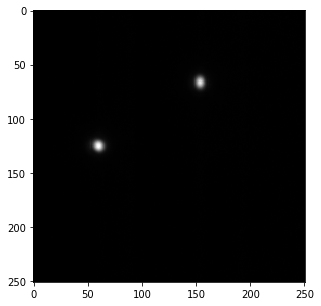

In [11]:
i = 0
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.imshow(images[i], cmap='gray');

### Export Image with Scale Bar

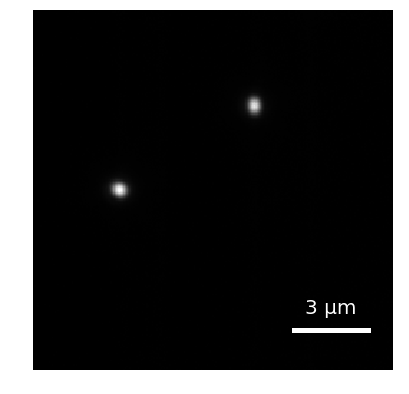

In [7]:
mpp = 0.0577*binning # micrometer per pixel ... this value depends on the microscope setup
sbar_m = 3 # length of the scale bar in micrometer
sbar_p = int(np.round(sbar_m/mpp)) # length of the scale bar in pixel
sbar_x = 0.825*dimx # relative x and y positions of the scale bar
sbar_y = 0.825*dimy 

fig, ax = plt.subplots(1, 1, figsize=(5,5)) # dpi=100

ax.imshow(images[i], cmap='gray')
ax.plot([sbar_x-sbar_p/2, sbar_x+sbar_p/2], [1.075*sbar_x, 1.075*sbar_y], 'w', lw=5);
ax.text(sbar_x, sbar_y, str(sbar_m) + ' µm', va='center', ha='center', color='w', fontsize=20)

fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
plt.axis('off')
plt.savefig(file.replace('_movie.tdms','.png'), dpi=300)

### Find Features

Required packages

In [13]:
import skimage
from skimage import morphology    
import pandas as pd

Define a method to find features based on connected component labeling:

In [14]:
def findFeatures(i, image, threshold, min_area, max_area):
    df = pd.DataFrame()
    threshold_image = (image > threshold).astype(int) # threshold
    label_image = skimage.measure.label(threshold_image)
    regions = skimage.measure.regionprops(label_image=label_image, intensity_image=image) # http://scikit-image.org/docs/dev/api/skimage.measure.html
    for region in regions:
        if region.area < min_area or region.area > max_area: # do not add feature if area is to small or to large
            continue
        df = df.append([{'y': region.centroid[0], 
                         'x': region.centroid[1],
                         'area': region.area,
                         'max_intensity': region.max_intensity,
                         'frame': i,}])
    return df, threshold_image

Run the method and show the tracked features along the the threshold image:

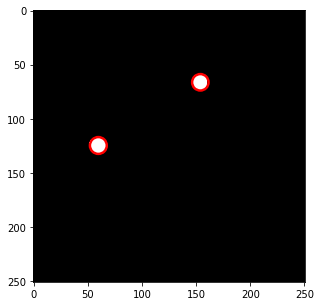

In [15]:
i = 0
threshold = 1000
min_area = 25 
max_area = 250

df, threshold_image = findFeatures(i, images[i], threshold, min_area, max_area)
    
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.imshow(threshold_image, cmap='gray')
for i, f in df.iterrows():
    c = plt.Circle((f.x, f.y), np.sqrt(f.area/pi), color='r', linewidth=2.5, fill=False)
    ax.add_patch(c)
    
plt.show()

Do the tracking for all images in the image series and append features to a data frame. *This may take a some seconds ...*

In [16]:
f = pd.DataFrame()
for i, image in enumerate(images):
    df,_ = findFeatures(i, image, threshold, min_area, max_area)
    f = f.append(df) 

In [17]:
f.head()

,area,frame,max_intensity,x,y
0,181,0,10843,153.834254,66.265193
0,190,0,11957,59.657895,124.615789
0,200,1,9618,156.890000,63.420000
0,222,1,9098,57.432432,122.477477
0,180,2,10708,153.916667,58.805556


### Working with HDF5 Files

To store data frames along with metadata we use the HDF5 file format. To learn more about the HFD5 file format see: http://www.hdfgroup.org <br>
The example below shows how to store the features along with some relevant metadata in a single HDF5 file.

In [18]:
with pd.HDFStore(file.replace('_movie', '') + '_features.h5', 'w') as store:
    store.put('features', f)
    metadata = pd.DataFrame([{'dimx': dimx, 'dimy': dimx, 'binning': binning, 'frames': frames, 'exposure': exposure}])
    metadata['method'] = 'Measure Labels'
    metadata['threshold'] = threshold
    metadata['min_area'] = min_area
    metadata['max_area'] = max_area
    store.put('metadata', metadata)
    store.close()

Here, we reload the HDF5 file and recover the data frames for demonstation purposes

In [19]:
with pd.HDFStore(file.replace('_movie.tdms', '') + '_features.h5', 'r') as store:
    df = store['features']
    metadata = store['metadata'].to_dict('records')[0]
    store.close()

In [20]:
df.head()

,area,frame,max_intensity,x,y
0,181,0,10843,153.834254,66.265193
0,190,0,11957,59.657895,124.615789
0,200,1,9618,156.890000,63.420000
0,222,1,9098,57.432432,122.477477
0,180,2,10708,153.916667,58.805556


In [21]:
metadata

{'binning': 1,
 'dimx': 251,
 'dimy': 251,
 'exposure': 0.015,
 'frames': 1000,
 'method': 'Measure Labels',
 'threshold': 1000,
 'min_area': 25,
 'max_area': 250}

## Link Trajectories

We link trajectories using the package Trackpy. In order to use the package you have to import it:

In [2]:
import trackpy as tp

If you run Python for the first time you may have to install the package. To install the package open the command-line and type:<br>
>`pip install trackpy`

Besides the linking functionality Trackpy comes with a lot of useful features. To learn more check out: https://soft-matter.github.io/trackpy/v0.3.2/

In [1]:
search_range = 25 # maximum step size in pixels
memory = 3 # numer of frames a particle can 

t1 = tp.link_df(df, search_range=search_range, memory=memory)

NameError: name 'tp' is not defined

Keep only trajectories that last for a given number of frames:

In [60]:
min_length = 10
t = tp.filter_stubs(t1, min_length)

(251, 0)

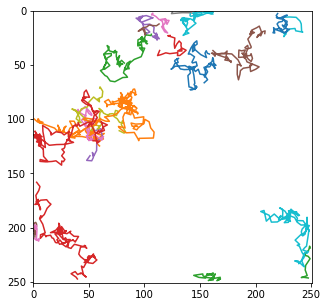

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
for j in range(t['particle'].max()):
    ax.plot(t[t['particle']==j].x, t[t['particle']==j].y)
ax.set_xlim(0, dimx)
ax.set_ylim(dimy, 0)

Here, we repeat the linking and store the trajectories in a HDF5

In [62]:
import os

In [63]:
search_range = 25
memory = 3
min_length = 10

# only link trajectories if there is no trajectories HDF5 file or if link is set True  
link = False
if not os.path.exists(file.replace('_movie.tdms', '') + '_trajectories.h5') or link: 
    t1 = tp.link_df(df, search_range=search_range, memory=memory) # depending on the number of frames this may take a while
    t = tp.filter_stubs(t1, min_length)
    store = pd.HDFStore(file.replace('_movie.tdms', '') + '_trajectories.h5', 'w')
    store.put('trajectories', t)
    store.close()
else:
    with pd.HDFStore(file.replace('_movie.tdms', '') + '_trajectories.h5', 'r') as store:
        t = store['trajectories']
        store.close()

## Handling Multiple Files

To limit the file size many experiments require to save data in multiple, sequential TDMS files rather than one large TDMS file. The following code snipet demonstates how to load and concatenate sequential TDMS and HDF5 files

List all TDMS files with the prefix Set1*:

In [67]:
import glob

for file in glob.glob('Set1_*_movie.tdms'):
    print(file)

Set1_001_movie.tdms
Set1_002_movie.tdms


Do the feature detection for all listed files and create a HDF5 feature file for each TDMS file

In [71]:
for file in glob.glob('Set1_*_movie.tdms'):
    f = pd.DataFrame()
    for i, image in enumerate(images):
        df, _ = findFeatures(i, image, threshold, min_area, max_area)
        f = f.append(df) 
    with pd.HDFStore(file.replace('_movie.tdms', '') + '_features.h5', 'w') as store:
        store.put('features', f)
        store.close()

Reload the feature files and concetanate the data frames

In [ ]:
f = pd.DataFrame()
features = pd.DataFrame()
for i, file in enumerate(glob.glob('Set1_*_movie.tdms')):
    features = pd.read_pickle(file)
    if i == 0:
        f = features
    else:
        features['frame'] += f['frame'].max()
        f = f.append(features)